<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# created by ??? cannot find link

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Step 1: Define Variational Autoencoder (VAE) Model
# updated the sizes for mnist dataset
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # Encoder: Convolutional layers to downsample the input
        self.encoder = nn.Sequential(
            # nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            # floor((32 - 3 + 1 + 2 * 0)/2) + 1 = 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(),
        )


        # Latent vectors `mu` and `log_var`
        # self.fc_mu = nn.Linear(256*4*4, latent_dim)     # Mean of the latent space
        # self.fc_log_var = nn.Linear(256*4*4, latent_dim) # Log-variance of the latent space
        self.fc_mu = nn.Linear(256*3*3, latent_dim)     # Mean of the latent space
        self.fc_log_var = nn.Linear(256*3*3, latent_dim) # Log-variance of the latent space



        # Decoder: Fully connected + transposed convolutions to upsample the latent representation
        # self.fc_decoder = nn.Linear(latent_dim, 256*4*4)
        self.fc_decoder = nn.Linear(latent_dim, 256*3*3)

        self.decoder = nn.Sequential(
            # output size (I−1)S−2P+K
            # (3 - 1) * 2 - 2 * 1 + 4 = 4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            # nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 1, kernel_size=6, stride=2, padding=0),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Encodes the input into latent space"""
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the image to a vector
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """Sample from a Gaussian distribution using the reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decodes the latent variable `z` back to an image"""
        x = self.fc_decoder(z)
        # x = x.view(x.size(0), 256, 4, 4)  # Reshape to image size
        x = x.view(x.size(0), 256, 3, 3)  # Reshape to image size
        x = self.decoder(x)
        return x

    def forward(self, x):
        """Forward pass through VAE"""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 2: Define the loss function (Reconstruction loss + KL Divergence)
# def vae_loss(reconstructed, original, mu, log_var):
#     # Reconstruction loss (binary cross entropy)
#     recon_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction='sum')

#     # KL Divergence loss (encourages the latent space to be Gaussian)
#     kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

#     return recon_loss + kl_divergence


# note the vae loss function is the core why it works
# see explanation here: https://spaces.ac.cn/archives/5343
def vae_loss(reconstructed, original, mu, log_var):
    # Reconstruction loss using Mean Squared Error (MSE)
    recon_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')

    # KL Divergence loss (encourages the latent space to be Gaussian)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_divergence

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def load_mnist_data(batch_size=100):
    """
    Loads and preprocesses the MNIST dataset using PyTorch's DataLoader.
    """
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts to tensor and scales to [0, 1]
    ])

    # Check if data directory exists, create if not
    data_dir = './data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


In [3]:
# Step 3: Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

trainloader = load_mnist_data(batch_size=64)[0]

# Step 4: Initialize VAE model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.68MB/s]


Epoch [1/10], Step [3/938], Loss: 10118.568359375
Epoch [1/10], Step [103/938], Loss: 3822.009033203125
Epoch [1/10], Step [203/938], Loss: 3251.144775390625
Epoch [1/10], Step [303/938], Loss: 3087.291748046875
Epoch [1/10], Step [403/938], Loss: 2604.3916015625
Epoch [1/10], Step [503/938], Loss: 2406.27197265625
Epoch [1/10], Step [603/938], Loss: 2473.601806640625
Epoch [1/10], Step [703/938], Loss: 2544.57958984375
Epoch [1/10], Step [803/938], Loss: 2137.339111328125
Epoch [1/10], Step [903/938], Loss: 2415.307861328125
Epoch [1/10], Loss: 2908.3513157565967
Epoch [2/10], Step [3/938], Loss: 2218.801513671875
Epoch [2/10], Step [103/938], Loss: 2336.963134765625
Epoch [2/10], Step [203/938], Loss: 2164.17529296875
Epoch [2/10], Step [303/938], Loss: 2227.83837890625
Epoch [2/10], Step [403/938], Loss: 2216.164794921875
Epoch [2/10], Step [503/938], Loss: 1965.25927734375
Epoch [2/10], Step [603/938], Loss: 2036.0606689453125
Epoch [2/10], Step [703/938], Loss: 2062.302978515625
E

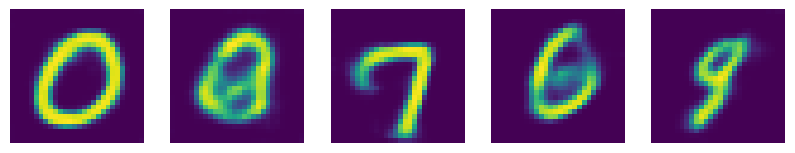

In [4]:
# Step 5: Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through the model
        reconstructed, mu, log_var = model(inputs)

        # Compute VAE loss
        loss = vae_loss(reconstructed, inputs, mu, log_var)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 2:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item()}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader)}')

print('Finished Training')

# Step 6: Sample from the latent space to generate new images
def sample_from_latent_space(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 128).to(device)  # Sample random latent vectors
        generated_images = model.decode(z)
        generated_images = generated_images.cpu()

    # Plot the generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i].permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.show()

# Generate new images
sample_from_latent_space(model, num_samples=5)